# Mridangam Real-Time Inference Pipeline

This notebook implements a real-time audio inference pipeline for mridangam stroke classification.

## Features:
- Real-time audio capture from microphone
- Onset detection for mridangam strokes
- CNN model inference
- Live visualization of predictions
- Audio buffering and processing

## Requirements:
- Trained CNN model weights
- Audio input device (microphone)
- Python libraries: torch, librosa, pyaudio, matplotlib

In [1]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Uncomment and run if you need to install packages
# install_package("pyaudio")
# install_package("librosa")
# install_package("torch")
# install_package("matplotlib")
# install_package("numpy")
# install_package("scipy")

In [4]:
# Import required libraries
import torch
import torch.nn as nn
import librosa
import numpy as np
import pyaudio
import threading
import queue
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
from collections import deque
from pathlib import Path
import json
from typing import Optional, List, Tuple

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Librosa version: {librosa.__version__}")

Libraries imported successfully!
PyTorch version: 2.7.1+cpu
Librosa version: 0.11.0


In [5]:
# Define the CNN Model Architecture (same as training)
class MridangamCNN(nn.Module):
    def __init__(self, n_mels=128, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # input shape: (1, 128, 128)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
            nn.Dropout(p=0.4),
            nn.AdaptiveAvgPool2d((1, None)),
        )

        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        x = self.classifier(x)
        return x

print("CNN Model architecture defined!")

CNN Model architecture defined!


In [6]:
# Audio processing functions
def get_onset(audio: np.array, sr: float) -> Optional[float]:
    """
    Detect onset in audio signal for mridangam percussion.
    """
    try:
        # Method 1: Spectral flux
        spectral_onsets = librosa.onset.onset_detect(
            y=audio, sr=sr, units='time',
            onset_envelope=librosa.onset.onset_strength(y=audio, sr=sr),
            pre_max=3, post_max=3, pre_avg=3, post_avg=3,
            delta=0.3, wait=5
        )
        
        # Method 2: Energy-based
        rms_features = librosa.feature.rms(y=audio)[0]
        rms_diff = np.diff(rms_features, prepend=rms_features[0])
        rms_diff = np.maximum(0, rms_diff)
        
        energy_onsets = librosa.onset.onset_detect(
            onset_envelope=rms_diff,
            sr=sr, units='time',
            pre_max=3, post_max=3, pre_avg=3, post_avg=3,
            delta=0.4, wait=5
        )
        
        # Combine onsets
        all_onsets = np.concatenate([spectral_onsets, energy_onsets])
        
        if len(all_onsets) > 0:
            all_onsets = np.sort(all_onsets)
            unique_onsets = [all_onsets[0]]
            for onset in all_onsets[1:]:
                if onset - unique_onsets[-1] > 0.05:  # 50ms threshold
                    unique_onsets.append(onset)
            return unique_onsets[0] if unique_onsets else None
        return None
    except:
        return None

def get_window(onset: float, audio: np.array, sr: float, 
               pre_onset: float = 0.05, post_onset: float = 0.15) -> np.array:
    """
    Extract audio window around onset.
    """
    duration = pre_onset + post_onset
    window_samples = int(duration * sr)
    
    if onset is None:
        if len(audio) >= window_samples:
            return audio[:window_samples]
        else:
            return np.pad(audio, (0, window_samples - len(audio)), mode='constant')
    
    # Calculate window boundaries
    pre_onset_duration = duration * 0.25
    start_time = max(0, onset - pre_onset_duration)
    end_time = start_time + duration
    
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # Handle edge cases
    if end_sample > len(audio):
        end_sample = len(audio)
        start_sample = max(0, end_sample - window_samples)
    
    window = audio[start_sample:end_sample]
    
    # Ensure exact duration
    if len(window) < window_samples:
        window = np.pad(window, (0, window_samples - len(window)), mode='constant')
    elif len(window) > window_samples:
        window = window[:window_samples]
    
    return window

def get_mel_spectrogram(audio: np.array, sr: float, target_length: int = 128) -> np.array:
    """
    Compute mel spectrogram for CNN input.
    """
    # Dynamic n_fft sizing
    max_n_fft = min(512, len(audio))
    n_fft = max(256, max_n_fft)
    hop_length = n_fft // 2
    
    # Ensure audio is long enough
    if len(audio) < n_fft:
        audio = np.pad(audio, (0, n_fft - len(audio)), mode='constant')
    
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128
    )
    
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Pad or truncate to target length
    n_mels, time_frames = mel_spectrogram_db.shape
    if time_frames < target_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, 
                                    ((0, 0), (0, target_length - time_frames)), 
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :target_length]
    
    return mel_spectrogram_db

def preprocess_audio_for_inference(audio: np.array, sr: float) -> torch.Tensor:
    """
    Complete preprocessing pipeline for inference.
    """
    try:
        # Detect onset
        onset = get_onset(audio, sr)
        
        # Get window around onset
        audio_window = get_window(onset, audio, sr)
        
        # Get mel spectrogram
        mel_spec = get_mel_spectrogram(audio_window, sr)
        
        # Convert to tensor and add batch dimension
        mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).unsqueeze(0)  # (1, 1, 128, 128)
        
        return mel_tensor
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # Return zero tensor as fallback
        return torch.zeros(1, 1, 128, 128)

print("Audio processing functions defined!")

Audio processing functions defined!


In [7]:
# Load the trained model
def load_model(model_path: str, num_classes: int = 10):
    """
    Load the trained CNN model.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model
    model = MridangamCNN(n_mels=128, num_classes=num_classes)
    
    try:
        # Try loading complete model with metadata
        checkpoint = torch.load(model_path, map_location=device)
        
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Complete model with metadata
            model.load_state_dict(checkpoint['model_state_dict'])
            
            # Extract metadata if available
            classes = checkpoint.get('classes', [f'class_{i}' for i in range(num_classes)])
            label_encoder = checkpoint.get('label_encoder', None)
            
            print(f"Loaded complete model with metadata")
            print(f"Classes: {classes}")
            
            return model.to(device), classes, label_encoder
        else:
            # Just state dict
            model.load_state_dict(checkpoint)
            classes = [f'class_{i}' for i in range(num_classes)]
            
            print(f"Loaded model state dict")
            return model.to(device), classes, None
            
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

# Set model path (adjust as needed)
MODEL_PATH = "../model_weights/mridangam_model_complete.pth"  # Try complete model first
FALLBACK_PATH = "../model_weights/mridangam_model_final.pth"  # Fallback to state dict

# Load model
model, class_names, label_encoder = load_model(MODEL_PATH)

if model is None:
    print(f"Trying fallback path: {FALLBACK_PATH}")
    model, class_names, label_encoder = load_model(FALLBACK_PATH)

if model is not None:
    model.eval()
    device = next(model.parameters()).device
    print(f"Model loaded successfully on {device}")
    print(f"Model expects input shape: (batch_size, 1, 128, 128)")
    print(f"Output classes: {class_names}")
else:
    print("Failed to load model. Please check the model path.")

Error loading model: [Errno 2] No such file or directory: '../model_weights/mridangam_model_complete.pth'
Trying fallback path: ../model_weights/mridangam_model_final.pth
Loaded model state dict
Model loaded successfully on cpu
Model expects input shape: (batch_size, 1, 128, 128)
Output classes: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


In [8]:
# Real-time Audio Capture Class
class RealTimeAudioCapture:
    def __init__(self, sample_rate=22050, chunk_size=1024, buffer_duration=2.0):
        self.sample_rate = sample_rate
        self.chunk_size = chunk_size
        self.buffer_duration = buffer_duration
        self.buffer_size = int(sample_rate * buffer_duration)
        
        # Audio buffer
        self.audio_buffer = deque(maxlen=self.buffer_size)
        
        # PyAudio setup
        self.audio = pyaudio.PyAudio()
        self.stream = None
        
        # Threading
        self.is_recording = False
        self.audio_thread = None
        
        # Detection parameters
        self.energy_threshold = 0.01  # Adjust based on your environment
        self.min_stroke_interval = 0.1  # Minimum time between strokes (seconds)
        self.last_detection_time = 0
        
    def start_recording(self):
        """Start audio recording in a separate thread."""
        try:
            self.stream = self.audio.open(
                format=pyaudio.paFloat32,
                channels=1,
                rate=self.sample_rate,
                input=True,
                frames_per_buffer=self.chunk_size,
                stream_callback=self._audio_callback
            )
            
            self.is_recording = True
            self.stream.start_stream()
            print(f"Audio recording started. Sample rate: {self.sample_rate} Hz")
            print(f"Buffer duration: {self.buffer_duration} seconds")
            return True
            
        except Exception as e:
            print(f"Error starting audio recording: {e}")
            return False
    
    def _audio_callback(self, in_data, frame_count, time_info, status):
        """Callback function for audio stream."""
        if status:
            print(f"Audio callback status: {status}")
        
        # Convert bytes to numpy array
        audio_data = np.frombuffer(in_data, dtype=np.float32)
        
        # Add to buffer
        self.audio_buffer.extend(audio_data)
        
        return (None, pyaudio.paContinue)
    
    def get_recent_audio(self, duration=1.0):
        """Get recent audio from buffer."""
        if len(self.audio_buffer) == 0:
            return np.array([])
        
        samples_needed = int(duration * self.sample_rate)
        samples_available = min(samples_needed, len(self.audio_buffer))
        
        # Get most recent audio
        recent_audio = np.array(list(self.audio_buffer)[-samples_available:])
        return recent_audio
    
    def detect_stroke(self, audio_window):
        """Simple stroke detection based on energy."""
        if len(audio_window) == 0:
            return False
        
        # Calculate RMS energy
        rms_energy = np.sqrt(np.mean(audio_window**2))
        
        # Check if energy exceeds threshold and enough time has passed
        current_time = time.time()
        time_since_last = current_time - self.last_detection_time
        
        if rms_energy > self.energy_threshold and time_since_last > self.min_stroke_interval:
            self.last_detection_time = current_time
            return True
        
        return False
    
    def stop_recording(self):
        """Stop audio recording."""
        self.is_recording = False
        
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        
        self.audio.terminate()
        print("Audio recording stopped.")

print("RealTimeAudioCapture class defined!")

RealTimeAudioCapture class defined!


In [9]:
# Real-time Inference Pipeline
class MridangamInferencePipeline:
    def __init__(self, model, class_names, audio_capture):
        self.model = model
        self.class_names = class_names
        self.audio_capture = audio_capture
        self.device = next(model.parameters()).device
        
        # Prediction history
        self.prediction_history = deque(maxlen=50)
        self.confidence_history = deque(maxlen=50)
        self.time_history = deque(maxlen=50)
        
        # Statistics
        self.total_predictions = 0
        self.high_confidence_predictions = 0
        
    def predict_stroke(self, audio_window):
        """Predict mridangam stroke from audio window."""
        try:
            # Preprocess audio
            mel_tensor = preprocess_audio_for_inference(audio_window, self.audio_capture.sample_rate)
            mel_tensor = mel_tensor.to(self.device)
            
            # Model inference
            with torch.no_grad():
                outputs = self.model(mel_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()
                confidence = torch.max(probabilities).item()
            
            # Get class name
            predicted_stroke = self.class_names[predicted_class] if predicted_class < len(self.class_names) else f"class_{predicted_class}"
            
            # Update statistics
            self.total_predictions += 1
            if confidence > 0.7:
                self.high_confidence_predictions += 1
            
            # Store in history
            current_time = time.time()
            self.prediction_history.append(predicted_stroke)
            self.confidence_history.append(confidence)
            self.time_history.append(current_time)
            
            return predicted_stroke, confidence, probabilities.cpu().numpy()[0]
            
        except Exception as e:
            print(f"Error in prediction: {e}")
            return "error", 0.0, np.zeros(len(self.class_names))
    
    def get_statistics(self):
        """Get prediction statistics."""
        if self.total_predictions == 0:
            return {
                'total_predictions': 0,
                'high_confidence_rate': 0.0,
                'avg_confidence': 0.0,
                'recent_predictions': []
            }
        
        recent_predictions = list(self.prediction_history)[-10:]  # Last 10 predictions
        avg_confidence = np.mean(list(self.confidence_history)) if self.confidence_history else 0.0
        high_confidence_rate = self.high_confidence_predictions / self.total_predictions
        
        return {
            'total_predictions': self.total_predictions,
            'high_confidence_rate': high_confidence_rate,
            'avg_confidence': avg_confidence,
            'recent_predictions': recent_predictions
        }

print("MridangamInferencePipeline class defined!")

MridangamInferencePipeline class defined!


In [10]:
# Visualization and Monitoring
class RealtimeVisualizer:
    def __init__(self, inference_pipeline, audio_capture):
        self.pipeline = inference_pipeline
        self.audio_capture = audio_capture
        
        # Setup matplotlib for real-time plotting
        plt.ion()  # Turn on interactive mode
        self.fig, self.axes = plt.subplots(2, 2, figsize=(12, 8))
        self.fig.suptitle('Mridangam Real-Time Inference Dashboard', fontsize=14, fontweight='bold')
        
        # Initialize plots
        self.init_plots()
        
    def init_plots(self):
        """Initialize plot layouts."""
        # Audio waveform plot
        self.axes[0, 0].set_title('Real-Time Audio Waveform')
        self.axes[0, 0].set_xlabel('Time (samples)')
        self.axes[0, 0].set_ylabel('Amplitude')
        self.waveform_line, = self.axes[0, 0].plot([], [], 'b-', linewidth=0.5)
        
        # Prediction confidence plot
        self.axes[0, 1].set_title('Prediction Confidence Over Time')
        self.axes[0, 1].set_xlabel('Time')
        self.axes[0, 1].set_ylabel('Confidence')
        self.axes[0, 1].set_ylim(0, 1)
        self.confidence_line, = self.axes[0, 1].plot([], [], 'g-', linewidth=2)
        
        # Class probabilities bar chart
        self.axes[1, 0].set_title('Current Prediction Probabilities')
        self.axes[1, 0].set_xlabel('Stroke Classes')
        self.axes[1, 0].set_ylabel('Probability')
        self.axes[1, 0].set_ylim(0, 1)
        
        # Prediction history
        self.axes[1, 1].set_title('Recent Predictions')
        self.axes[1, 1].axis('off')
        
        plt.tight_layout()
        
    def update_plots(self, predicted_stroke, confidence, probabilities):
        """Update all plots with new data."""
        try:
            # Update audio waveform
            recent_audio = self.audio_capture.get_recent_audio(duration=1.0)
            if len(recent_audio) > 0:
                self.axes[0, 0].clear()
                self.axes[0, 0].plot(recent_audio, 'b-', linewidth=0.5)
                self.axes[0, 0].set_title('Real-Time Audio Waveform')
                self.axes[0, 0].set_xlabel('Time (samples)')
                self.axes[0, 0].set_ylabel('Amplitude')
                
            # Update confidence over time
            if len(self.pipeline.confidence_history) > 1:
                self.axes[0, 1].clear()
                confidence_data = list(self.pipeline.confidence_history)
                self.axes[0, 1].plot(confidence_data, 'g-', linewidth=2)
                self.axes[0, 1].axhline(y=0.7, color='r', linestyle='--', alpha=0.7, label='High Confidence Threshold')
                self.axes[0, 1].set_title('Prediction Confidence Over Time')
                self.axes[0, 1].set_xlabel('Prediction Number')
                self.axes[0, 1].set_ylabel('Confidence')
                self.axes[0, 1].set_ylim(0, 1)
                self.axes[0, 1].legend()
                
            # Update class probabilities
            self.axes[1, 0].clear()
            class_labels = [name[:8] + '...' if len(name) > 8 else name for name in self.pipeline.class_names]
            bars = self.axes[1, 0].bar(class_labels, probabilities)
            
            # Highlight predicted class
            max_idx = np.argmax(probabilities)
            bars[max_idx].set_color('red')
            
            self.axes[1, 0].set_title(f'Current Prediction: {predicted_stroke} ({confidence:.3f})')
            self.axes[1, 0].set_xlabel('Stroke Classes')
            self.axes[1, 0].set_ylabel('Probability')
            self.axes[1, 0].set_ylim(0, 1)
            self.axes[1, 0].tick_params(axis='x', rotation=45)
            
            # Update recent predictions text
            stats = self.pipeline.get_statistics()
            recent_preds = stats['recent_predictions'][-5:]  # Last 5 predictions
            
            self.axes[1, 1].clear()
            self.axes[1, 1].axis('off')
            
            # Create text summary
            text_lines = [
                f"Statistics:",
                f"Total Predictions: {stats['total_predictions']}",
                f"High Confidence Rate: {stats['high_confidence_rate']:.2%}",
                f"Average Confidence: {stats['avg_confidence']:.3f}",
                "",
                "Recent Predictions:"
            ]
            
            for i, pred in enumerate(recent_preds):
                text_lines.append(f"{len(recent_preds)-i}. {pred}")
            
            self.axes[1, 1].text(0.1, 0.9, '\n'.join(text_lines), 
                               transform=self.axes[1, 1].transAxes, 
                               fontsize=10, verticalalignment='top',
                               fontfamily='monospace')
            
            # Refresh display
            plt.pause(0.01)
            
        except Exception as e:
            print(f"Error updating plots: {e}")

print("RealtimeVisualizer class defined!")

RealtimeVisualizer class defined!


In [11]:
# Main Real-Time Inference Loop
def run_realtime_inference(duration_minutes=5, detection_interval=0.1):
    """
    Run the real-time inference pipeline.
    
    Args:
        duration_minutes: How long to run the inference (minutes)
        detection_interval: How often to check for strokes (seconds)
    """
    if model is None:
        print("Model not loaded. Please load the model first.")
        return
    
    print(f"Starting real-time inference for {duration_minutes} minutes...")
    print(f"Detection interval: {detection_interval} seconds")
    print("Play some mridangam sounds!")
    
    # Initialize components
    audio_capture = RealTimeAudioCapture(sample_rate=22050, chunk_size=1024, buffer_duration=3.0)
    inference_pipeline = MridangamInferencePipeline(model, class_names, audio_capture)
    visualizer = RealtimeVisualizer(inference_pipeline, audio_capture)
    
    # Start audio recording
    if not audio_capture.start_recording():
        print("Failed to start audio recording. Check your microphone.")
        return
    
    try:
        start_time = time.time()
        end_time = start_time + (duration_minutes * 60)
        
        print("\nListening for mridangam strokes...")
        print("Press Ctrl+C to stop early")
        
        while time.time() < end_time:
            try:
                # Get recent audio
                recent_audio = audio_capture.get_recent_audio(duration=1.5)
                
                if len(recent_audio) > 0:
                    # Check for stroke detection
                    if audio_capture.detect_stroke(recent_audio):
                        # Run inference
                        predicted_stroke, confidence, probabilities = inference_pipeline.predict_stroke(recent_audio)
                        
                        # Print prediction
                        timestamp = time.strftime("%H:%M:%S")
                        print(f"[{timestamp}] Detected: {predicted_stroke} (confidence: {confidence:.3f})")
                        
                        # Update visualization
                        visualizer.update_plots(predicted_stroke, confidence, probabilities)
                
                # Sleep for detection interval
                time.sleep(detection_interval)
                
            except KeyboardInterrupt:
                print("\nStopping inference...")
                break
            except Exception as e:
                print(f"Error in inference loop: {e}")
                time.sleep(detection_interval)
                
    finally:
        # Cleanup
        audio_capture.stop_recording()
        
        # Print final statistics
        stats = inference_pipeline.get_statistics()
        print("\n" + "="*50)
        print("FINAL STATISTICS")
        print("="*50)
        print(f"Total predictions: {stats['total_predictions']}")
        print(f"High confidence rate: {stats['high_confidence_rate']:.2%}")
        print(f"Average confidence: {stats['avg_confidence']:.3f}")
        print(f"Recent predictions: {stats['recent_predictions'][-5:]}")
        
        print("\nReal-time inference completed!")

print("Real-time inference function defined!")

Real-time inference function defined!


In [12]:
# Test audio devices and settings
def test_audio_setup():
    """Test audio input devices and basic recording."""
    print("Testing audio setup...")
    
    audio = pyaudio.PyAudio()
    
    # List audio devices
    print("\nAvailable audio devices:")
    for i in range(audio.get_device_count()):
        device_info = audio.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            print(f"  {i}: {device_info['name']} (channels: {device_info['maxInputChannels']})")
    
    # Test basic recording
    print("\nTesting basic audio recording for 3 seconds...")
    try:
        stream = audio.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=22050,
            input=True,
            frames_per_buffer=1024
        )
        
        print("Recording... (make some sound!)")
        
        # Record for 3 seconds
        audio_data = []
        for _ in range(int(22050 * 3 / 1024)):
            data = stream.read(1024)
            audio_data.append(np.frombuffer(data, dtype=np.float32))
        
        # Analyze recorded audio
        full_audio = np.concatenate(audio_data)
        rms_energy = np.sqrt(np.mean(full_audio**2))
        max_amplitude = np.max(np.abs(full_audio))
        
        print(f"Recording completed!")
        print(f"RMS Energy: {rms_energy:.6f}")
        print(f"Max Amplitude: {max_amplitude:.6f}")
        
        if rms_energy > 0.001:
            print("✅ Audio input working properly!")
        else:
            print("⚠️  Low audio level detected. Check microphone.")
        
        stream.stop_stream()
        stream.close()
        
    except Exception as e:
        print(f"❌ Error testing audio: {e}")
    
    audio.terminate()

# Run audio test
test_audio_setup()

Testing audio setup...

Available audio devices:
  0: Microsoft Sound Mapper - Input (channels: 2)
  1: Microphone Array (Realtek(R) Au (channels: 2)
  5: Primary Sound Capture Driver (channels: 2)
  6: Microphone Array (Realtek(R) Audio) (channels: 2)
  12: Microphone Array (Realtek(R) Audio) (channels: 2)
  13: Stereo Mix (Realtek HD Audio Stereo input) (channels: 2)
  16: PC Speaker (Realtek HD Audio 2nd output with SST) (channels: 2)
  17: Microphone Array (Realtek HD Audio Mic input) (channels: 2)
  20: PC Speaker (Realtek HD Audio output with SST) (channels: 2)
  22: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(JBL TUNE760NC)) (channels: 1)
  26: Headset (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(WH-1000XM4)) (channels: 1)
  27: Input () (channels: 2)
  29: Headset Microphone (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(LE-Bose Revolve+ SoundLink)) (channels: 1)
  31: Input (@System32\drivers\bthhfenum.sys,#4;%1 Hands-Free HF Audio%0
;(Achinty

In [13]:
# Configuration and Settings
print("Real-Time Mridangam Inference Pipeline Ready!")
print("="*60)
print("Configuration:")
print(f"  Model: {'Loaded' if model is not None else 'Not loaded'}")
print(f"  Device: {device if model is not None else 'N/A'}")
print(f"  Classes: {len(class_names) if class_names else 0}")
print(f"  Sample Rate: 22050 Hz")
print(f"  Input Shape: (1, 128, 128)")

if class_names:
    print(f"  Stroke Classes: {class_names}")

print("\nTo start real-time inference:")
print("  run_realtime_inference(duration_minutes=5)")
print("\nAdjustable parameters:")
print("  - duration_minutes: How long to run (default: 5)")
print("  - detection_interval: Detection frequency in seconds (default: 0.1)")
print("\nMake sure your microphone is working and positioned near the mridangam!")

Real-Time Mridangam Inference Pipeline Ready!
Configuration:
  Model: Loaded
  Device: cpu
  Classes: 10
  Sample Rate: 22050 Hz
  Input Shape: (1, 128, 128)
  Stroke Classes: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']

To start real-time inference:
  run_realtime_inference(duration_minutes=5)

Adjustable parameters:
  - duration_minutes: How long to run (default: 5)
  - detection_interval: Detection frequency in seconds (default: 0.1)

Make sure your microphone is working and positioned near the mridangam!


Starting real-time inference for 2 minutes...
Detection interval: 0.1 seconds
Play some mridangam sounds!
Audio recording started. Sample rate: 22050 Hz
Buffer duration: 3.0 seconds

Listening for mridangam strokes...
Press Ctrl+C to stop early
Audio recording started. Sample rate: 22050 Hz
Buffer duration: 3.0 seconds

Listening for mridangam strokes...
Press Ctrl+C to stop early
[10:56:52] Detected: class_2 (confidence: 1.000)
[10:56:52] Detected: class_2 (confidence: 1.000)


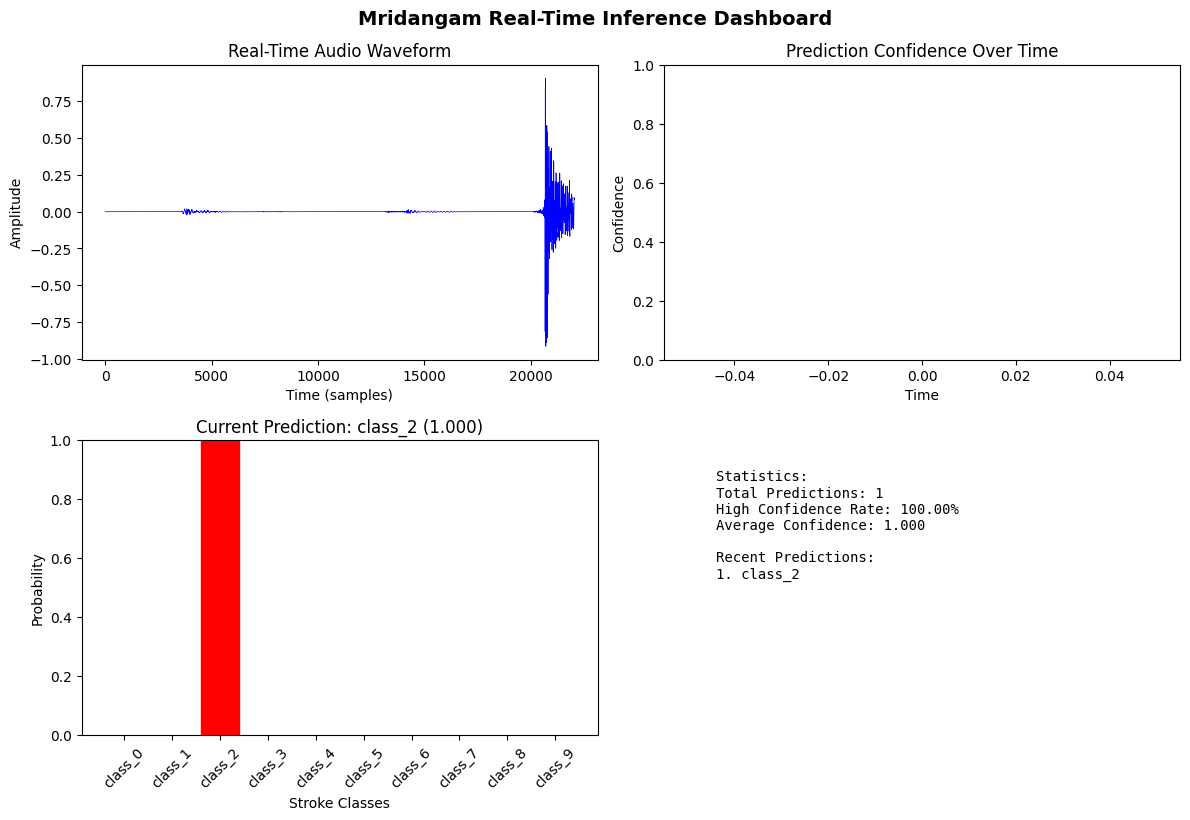

[10:56:52] Detected: class_2 (confidence: 1.000)
[10:56:52] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_2 (confidence: 1.000)
[10:56:53] Detected: class_9 (confidence: 1.000)
[10:56:53] Detected: class_9 (confidence: 1.000)
[10:56:53] Detected: class_9 (confidence: 1.000)
[10:56:53] Detected: class_9 (confidence: 1.000)
[10:56:54] Detected: class_2 (confidence: 1.000)
[10:56:54] Detected: class_2 (confidence: 1.000)
[10:56:54] Detected: class_2 (confidence: 1.000)
[10:56:54] Detected: class_2 (confidence: 1.000)
[10:56:54] Detected: class_2 (confidence: 0.994)
[10:56:54] Detected: class_2 (confidence: 0.994)
[10:56:54] Detected: class_2 (confidence: 0.994)
[10:56:54] Detected: class_2 (confidence: 0.994)
[10:56:54] Detected:

In [15]:
# START REAL-TIME INFERENCE
# Uncomment and run this cell to start the real-time inference

# Run for 5 minutes with detection every 0.1 seconds
run_realtime_inference(duration_minutes=2, detection_interval=0.1)

# Alternative configurations:
# run_realtime_inference(duration_minutes=1, detection_interval=0.05)  # More frequent detection
# run_realtime_inference(duration_minutes=10, detection_interval=0.2)  # Longer duration, less frequent